In [1]:
import cv2 as cv
import os
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch
from torch import nn
import shutil
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output


# Подготовка картинок

In [ ]:
from bing_image_downloader import downloader
import os

# Стили кастомных авто и поисковые запросы
car_styles = {
    # "muscle": "muscle car classic",
    # "jdm": "jdm car",
    # "stance": "stance car fitment",
    # "retro": "retro car oldschool",
    # "lowrider": "lowrider car custom",
    # "offroad": "offroad truck jeep",
    "Bosozoku": "Bosozoku car style"
}

# Основная директория для датасета
dataset_dir = "./dataset"

# Скачиваем по каждому стилю
for label, query in car_styles.items():
    downloader.download(query,
                        limit=200, 
                        output_dir=dataset_dir,
                        adult_filter_off=True,
                        force_replace=False,
                        timeout=60,
                        verbose=True)
    

    downloaded_path = os.path.join(dataset_dir, query)
    target_path = os.path.join(dataset_dir, label)
    if os.path.exists(downloaded_path):
        os.rename(downloaded_path, target_path)


[%] Downloading Images to e:\My projects\ML Yandex HandBook\classificator\dataset\Bosozoku car style


[!!]Indexing page: 1

[%] Indexed 32 Images on Page 1.


[%] Downloading Image #1 from https://i.pinimg.com/originals/3e/23/b5/3e23b5f2e43b7a0c6e0144fba80ea8a6.jpg


KeyboardInterrupt: 

Разделим весь датасет на обучающую и тренировочную выборку, чтобы в каждой папке изображения хранились по классам.

In [2]:

SOURCE_DIR = "dataset_custom_cars"
TARGET_DIR = "dataset_split"


for split in ["train", "test"]:
    split_path = os.path.join(TARGET_DIR, split)
    os.makedirs(split_path, exist_ok=True)

for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    train_data, test_data = train_test_split(images, test_size=0.3, random_state=42)
    splits = {
        "train": train_data,
        "test": test_data,
    }

    for split, files in splits.items():
        split_class_dir = os.path.join(TARGET_DIR, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for file in files:
            src = os.path.join(class_path, file)
            dst = os.path.join(split_class_dir, file)
            shutil.copy2(src, dst)



In [3]:

DATASET_PATH = "dataset_split"
BATCH_SIZE = 32
IMAGE_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_ds = datasets.ImageFolder(os.path.join(DATASET_PATH, "train"), transform=train_transforms)
test_ds = datasets.ImageFolder(os.path.join(DATASET_PATH, "test"), transform=test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)




In [4]:
train_ds[0][0].shape

torch.Size([3, 224, 224])

# Pipeline для обучения модели

Функция для переноса всего датасета на используемое устройство (cuda/cpu).

In [5]:
device = torch.device("cuda:0")

In [6]:
len(train_ds.classes)

6

In [66]:
# model = nn.Sequential(
#     nn.Conv2d(in_channels=3, out_channels=15, kernel_size=5),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Conv2d(in_channels=15, out_channels=40, kernel_size=5),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=5),
#     nn.Flatten(),
    
#     nn.Linear(25*25*40, 2000),
#     nn.ReLU(),
#     nn.Linear(2000, 1000),
#     nn.ReLU(),
#     nn.Linear(1000, 250),
#     nn.ReLU(),
#     nn.Linear(250, 5)
# ).to(device)

In [67]:
# model = models.convnext_tiny(weights=None).to(device)

In [10]:
from torchvision.models import resnet50

model = resnet50(pretrained=True).to(device)
model.fc = nn.Sequential(
    nn.Linear(2048, 128), 
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 6),
).to(device)

In [ ]:
# from torchvision.models import resnet18

# model = resnet18(pretrained=True).to(device)
# model.fc = nn.Sequential(
#     nn.Linear(512, 128), 
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(128, 5),
# ).to(device)

e:\My projects\ML Yandex HandBook\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\My projects\ML Yandex HandBook\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [79]:
# model = models.resnet18(weights=None)
# model.fc = nn.Linear(model.fc.in_features, 5)
# model = model.to(device)


In [80]:
# from vit_pytorch import ViT

# model = ViT(
#     image_size = 224,
#     patch_size = 32,
#     num_classes = 6,
#     dim = 1024,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1
# ).to(device)

In [81]:
# from vit_pytorch.na_vit import NaViT

# model = NaViT(
#     image_size = 512,
#     patch_size = 32,
#     num_classes = 6,
#     dim = 1024,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1,
#     token_dropout_prob = 0.1  # token dropout of 10% (keep 90% of tokens)
# ).to(device)

In [12]:
# optim = torch.optim.Adagrad(model.parameters(), lr = 5e-4)
from torch.optim.lr_scheduler import CosineAnnealingLR
optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optim, T_max=20)

In [13]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader) -> tuple[float, float]:
    model.eval()    

    total_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluation'):
            x = x.to(device)
            y = y.to(device)
            output = model(x)

            loss = loss_fn(output, y)

            total_loss += loss.item()

            _, y_pred = torch.max(output, 1)
            total += y.size(0)
            correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [14]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(10, 7))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Test loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(10, 7))

    plt.title(title + ' accuracy')

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()

In [15]:
len(train_ds)

610

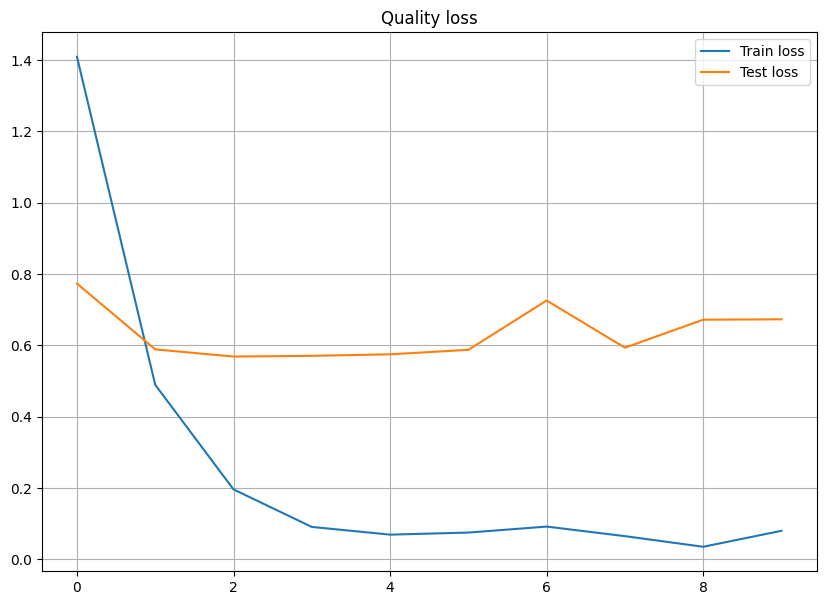

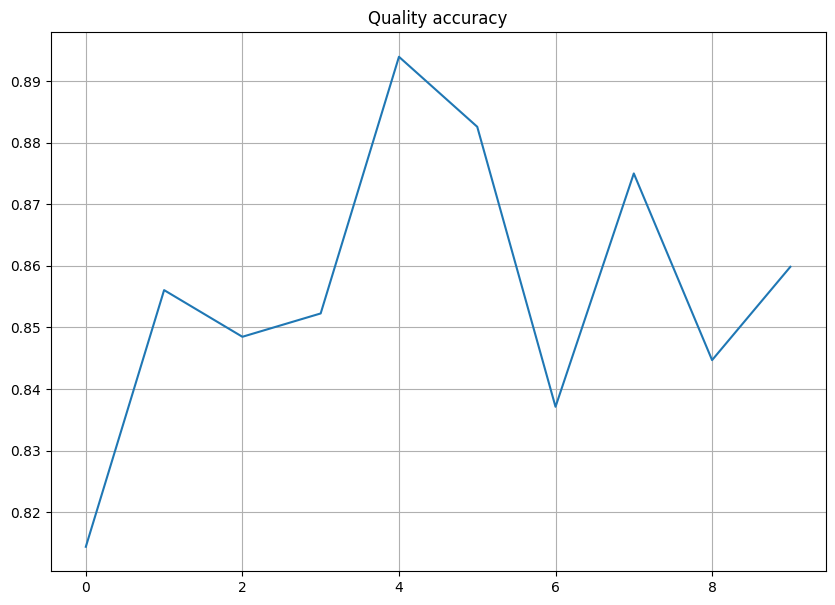

In [16]:
num_epoch = 10
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(num_epoch):
    print("Epoch", epoch)
    model.train()
    train_loss = 0
    
    for x,y in tqdm(train_loader, desc="Train"):
        x = x.to(device)
        y = y.to(device)
        optim.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optim.step()
    
    scheduler.step() 
    train_loss = train_loss/len(train_loader)
    test_loss, accuracy = evaluate(model, test_loader)
    
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(accuracy)

    clear_output()
    plot_stats(train_loss_history, test_loss_history, test_accuracy_history, title="Quality")




In [17]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


class_names = train_ds.classes  

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())





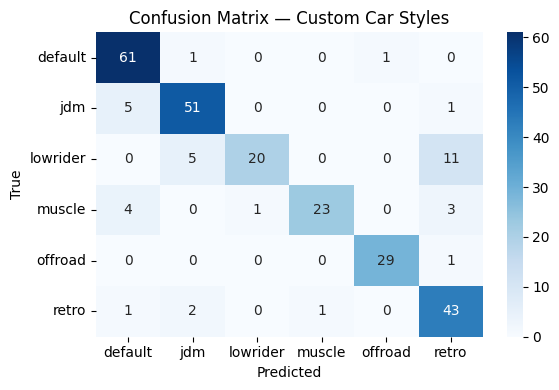

In [18]:
cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — Custom Car Styles')
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'my_model.pth')


In [35]:
scripted_model = torch.jit.script(model)
torch.jit.save(scripted_model, "model_scripted_resnet50_6_classes.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].


torch.Size([3, 224, 224])
Output: 3
True Output: tensor(3)


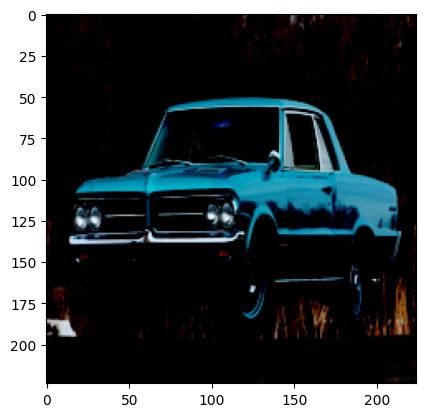

In [34]:
from torchvision import transforms
from PIL import Image


obj = next(iter(train_loader))
x = obj[0][0]
y = obj[1][0]
plt.imshow(x.permute(1, 2, 0).numpy())
print(x.shape)
image_input = x.unsqueeze(axis=0).to(torch.device("cuda:0"))
model_output = model(image_input).cpu().detach().numpy().squeeze()
print("Output:", np.argmax(np.exp(model_output)/sum(np.exp(model_output))))
print("True Output:", y)
